In [1]:
import sys

sys.path.append("../src/")

In [2]:
import os
import pathlib
from collections import defaultdict
from typing import Any, Dict, Optional, Union

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from rich.progress import track

%matplotlib inline


sns.set_style("darkgrid")
plt.style.use("seaborn-darkgrid")

pd.options.display.max_rows = 100
pd.options.display.max_columns = 500 

## Todo

- session_id, index の重複対応
  - インパクト小さい
  - 重複があるsession_idを除外して学習したが、精度が大きく改善することはなかった
- index, elapsed_timeを単調増加するように修正
  - インパクト大きそう
  - reindexする
- session内でlevelを逆走してるデータの対応
  - 逆走してる、してないフラグがあるだけでも？
  - levelを逆走しているのは258セッション存在する





In [3]:
train = pl.read_csv("../data/raw/train.csv")

In [4]:
train.head()

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
i64,i64,i64,str,str,i64,str,f64,f64,f64,f64,f64,str,str,str,str,i64,i64,i64,str
20090312431273200,0,0,"""cutscene_click…","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""undefined""","""intro""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,1,1323,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""Whatcha doing …","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,2,831,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""Just talking t…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,3,1147,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""I gotta run to…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,4,1863,"""person_click""","""basic""",0,null,-412.991405,-159.314686,381.0,494.0,null,"""Can I come, Gr…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""


session_idごとにelapsed_timeが単調増加していないデータを特定したい

In [40]:
def check_is_monotornic_increasing(df: pd.DataFrame, column: str) -> bool:
    return df[column].is_monotonic_increasing


reversed_session_ids = []

for session_id, gdf in track(train.groupby("session_id"), total=len(train["session_id"].unique())):
    is_monotornic_increasing = check_is_monotornic_increasing(gdf.to_pandas(), "index")
    if not is_monotornic_increasing:
        reversed_session_ids.append(session_id)

Output()

In [19]:
train["session_id"].n_unique()

23562

In [52]:
len(reversed_session_ids)

258

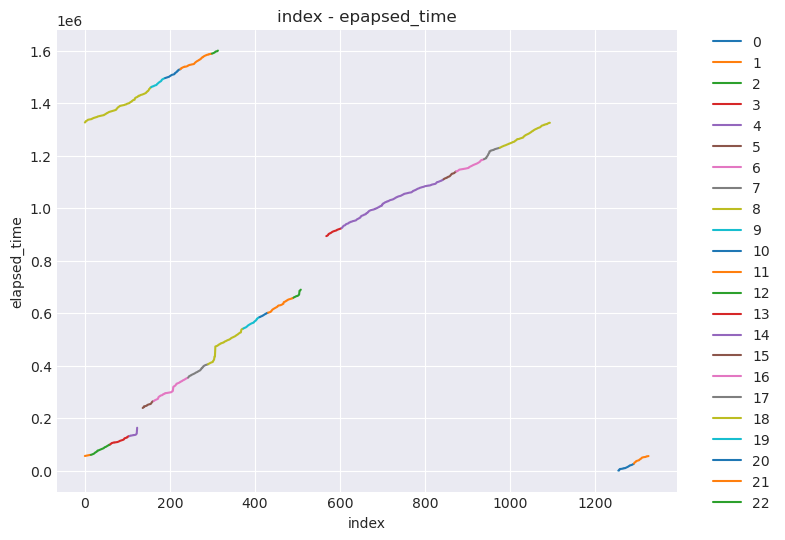

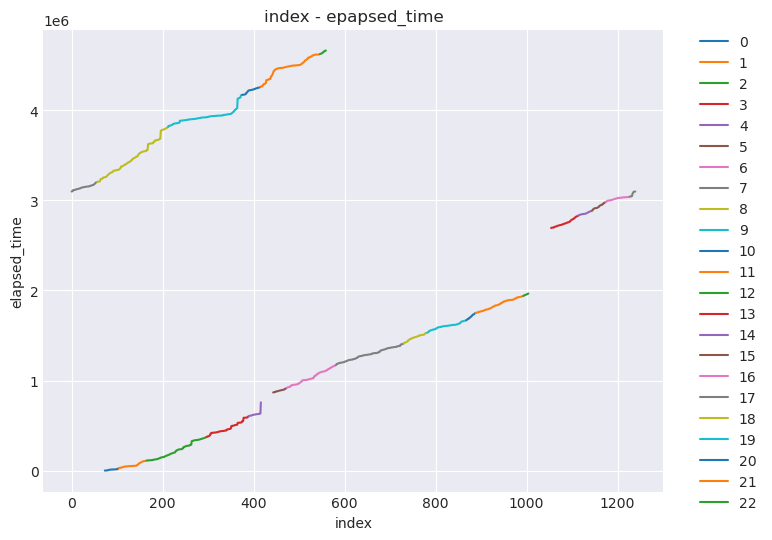

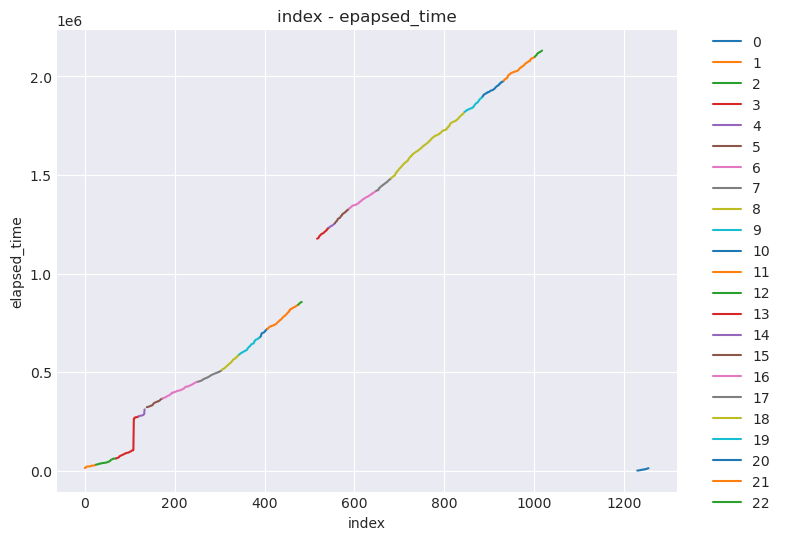

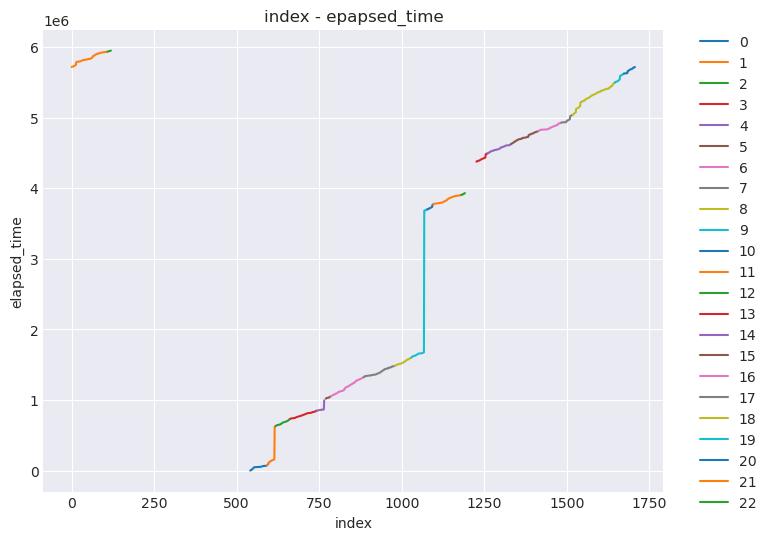

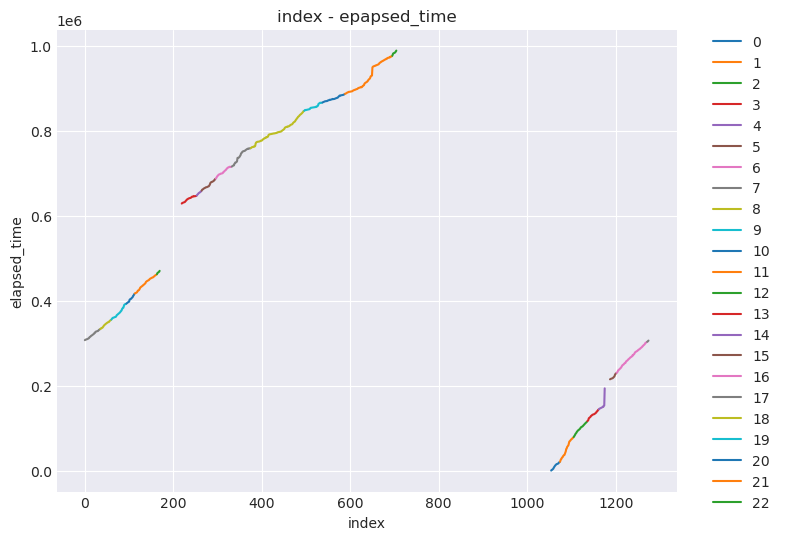

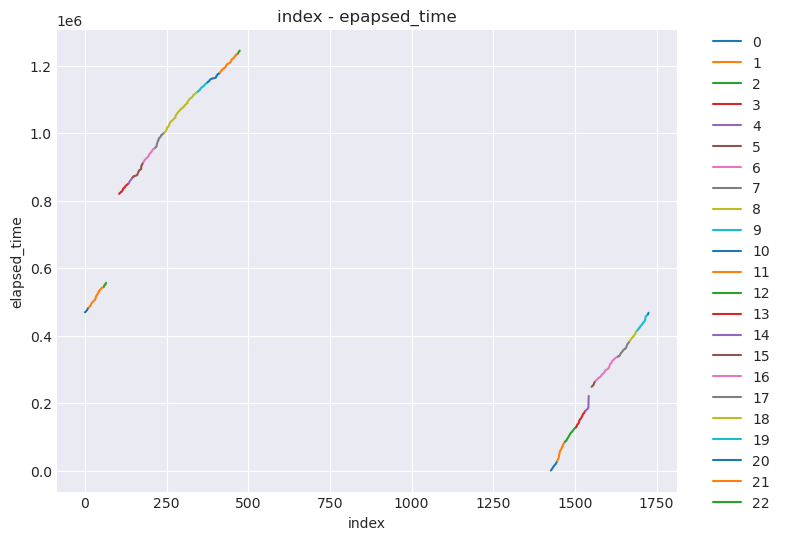

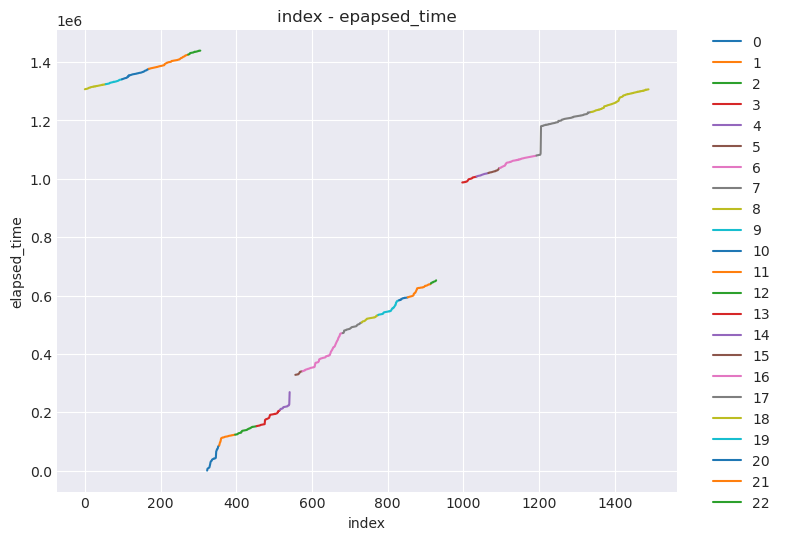

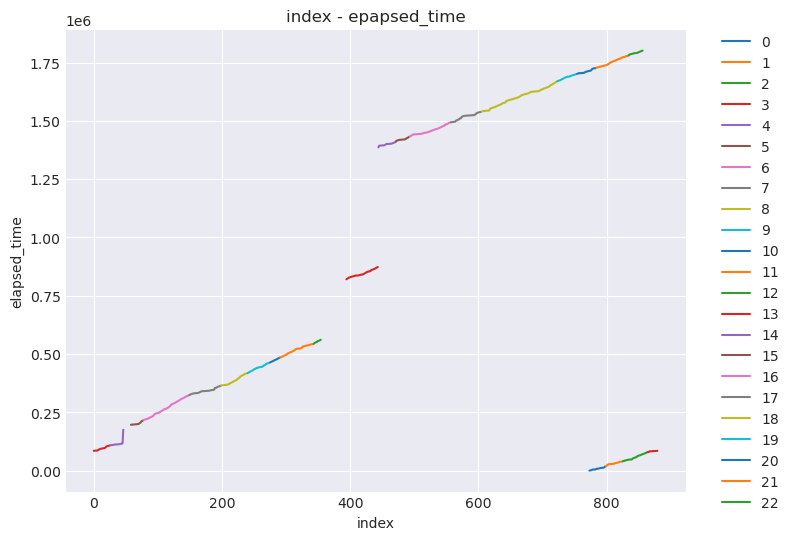

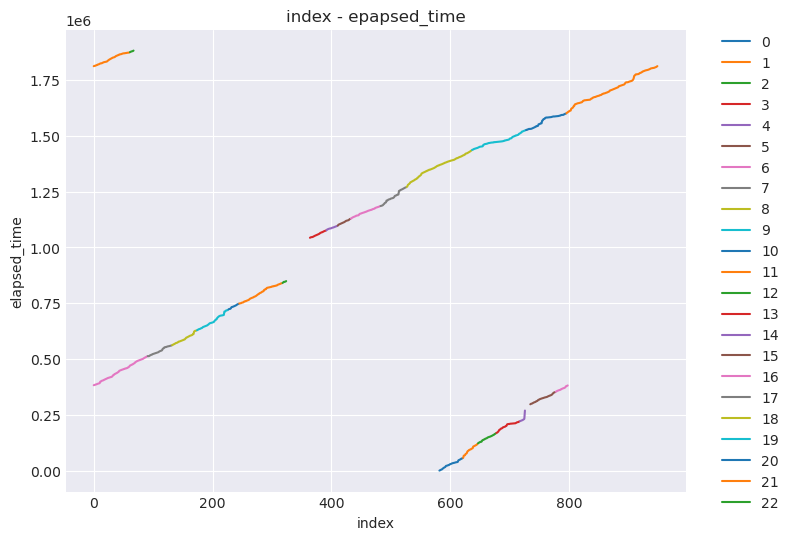

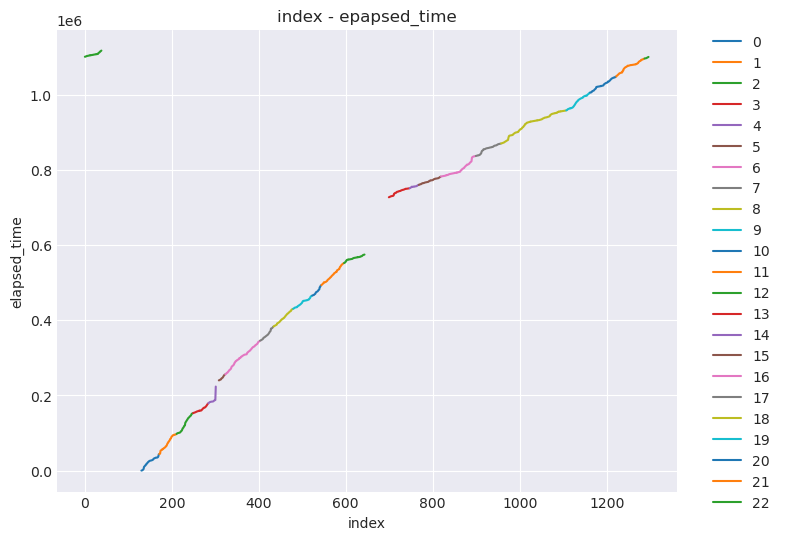

In [56]:
for session_id in reversed_session_ids[:10]:
    df_plot = train.filter(pl.col("session_id") == session_id).to_pandas()

    df_plot.pivot_table(
        index="index", columns="level", values="elapsed_time", aggfunc="first"
    ).plot(
        figsize=(8, 6), legend="upper left", title="index - epapsed_time", ylabel="elapsed_time"
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

In [62]:
smpl_data = train.filter(pl.col("session_id") == reversed_session_ids[0]).to_pandas()


smpl_data.pivot_table(index="index", columns="level", values="elapsed_time", aggfunc="first")

smpl_data.groupby("level")["elapsed_time"].agg(["mean", "std", "min", "max", "first", "last"])

,mean,std,min,max,first,last
level,,,,,,
0,1.255008e+04,7186.855924,0,25325,0,25325
1,4.845816e+04,9284.039702,26734,59770,26734,59770
2,7.952424e+04,11997.162089,60022,99003,60022,99003
3,1.143955e+05,8681.657020,100192,131155,100192,131155
4,1.365444e+05,6867.841415,131451,163294,131451,163294
5,2.509837e+05,7272.741027,238605,264623,238605,264623
6,3.090685e+05,27441.193570,265418,353363,265418,353363
7,3.800246e+05,15422.855073,354547,404788,354547,404788
8,4.838883e+05,39099.016523,405377,540730,405377,540730


In [5]:
train_duplicated = train.filter(train[["session_id", "index"]].is_duplicated()).sort(by=["session_id", "index"])

In [10]:
train_duplicated

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
i64,i64,i64,str,str,i64,str,f64,f64,f64,f64,f64,str,str,str,str,i64,i64,i64,str
20110422113670820,0,0,"""cutscene_click…","""basic""",0,null,-690.991405,87.685314,103.0,247.0,null,"""undefined""","""intro""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20110422113670820,0,981574,"""navigate_click…","""undefined""",18,null,620.665103,115.137848,766.0,250.0,null,null,"""tobasement""","""tunic.historic…",null,0,0,1,"""13-22"""
20110422113670820,1,297,"""person_click""","""basic""",0,null,-670.991405,82.685314,123.0,252.0,null,"""Whatcha doing …","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20110422113670820,1,982141,"""navigate_click…","""undefined""",18,null,152.534298,77.385367,400.0,278.0,null,null,"""groupconvo_fla…","""tunic.historic…",null,0,0,1,"""13-22"""
20110422113670820,2,546,"""person_click""","""basic""",0,null,-673.991405,91.685314,120.0,243.0,null,"""Just talking t…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20110422113670820,2,985210,"""cutscene_click…","""basic""",18,null,563.531872,255.28254,659.0,177.0,null,"""I'm telling yo…","""groupconvo_fla…","""tunic.historic…","""tunic.historic…",0,0,1,"""13-22"""
20110422113670820,3,757,"""person_click""","""basic""",0,null,-684.991405,83.685314,109.0,251.0,null,"""I gotta run to…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20110422113670820,3,987002,"""cutscene_click…","""basic""",18,null,517.583435,336.810012,631.0,127.0,null,"""Nonsense. I wa…","""groupconvo_fla…","""tunic.historic…","""tunic.historic…",0,0,1,"""13-22"""
20110422113670820,4,1010,"""person_click""","""basic""",0,null,-679.991405,86.685314,114.0,248.0,null,"""Can I come, Gr…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""


In [6]:
session_id_duplicated = train_duplicated["session_id"].to_list()

In [7]:
train_duplicated["session_id"].n_unique()

142

In [8]:
train["session_id"].n_unique()

23562

In [9]:
train.filter(~pl.col("session_id").is_in(session_id_duplicated))

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
i64,i64,i64,str,str,i64,str,f64,f64,f64,f64,f64,str,str,str,str,i64,i64,i64,str
20090312431273200,0,0,"""cutscene_click…","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""undefined""","""intro""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,1,1323,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""Whatcha doing …","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,2,831,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""Just talking t…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,3,1147,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""I gotta run to…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,4,1863,"""person_click""","""basic""",0,null,-412.991405,-159.314686,381.0,494.0,null,"""Can I come, Gr…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,5,3423,"""person_click""","""basic""",0,null,-412.991405,-157.314686,381.0,492.0,null,"""Sure thing, Jo…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,6,5197,"""person_click""","""basic""",0,null,478.485079,-199.971679,593.0,485.0,null,"""See you later,…","""teddy""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,7,6180,"""person_click""","""basic""",0,null,503.355128,-168.619913,609.0,453.0,null,"""I get to go to…","""teddy""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,8,7014,"""person_click""","""basic""",0,null,510.733442,-157.720642,615.0,442.0,null,"""Now where did …","""teddy""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
